<a href="https://colab.research.google.com/github/AyaAhmed01/Diabetes-detector/blob/main/RF_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For ML models
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

# For Data Processing
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from google.colab import files

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Miscellaneous
import os
import random

In [2]:
upload = files.upload()

Saving diabetes.csv to diabetes.csv


In [3]:
df = pd.read_csv('diabetes.csv')

In [4]:
# Feature Engineering
df['Diabetes'] = df['Outcome']
del df['Outcome']
df['Diabetes'] = df['Diabetes'].apply(lambda x:{1:True, 0:False}[x])

# Colums statistics 
df.describe()[1:].T.style.background_gradient(cmap='Blues')

,mean,std,min,25%,50%,75%,max
Pregnancies,3.845052,3.369578,0.000000,1.000000,3.000000,6.000000,17.000000
Glucose,120.894531,31.972618,0.000000,99.000000,117.000000,140.250000,199.000000
BloodPressure,69.105469,19.355807,0.000000,62.000000,72.000000,80.000000,122.000000
SkinThickness,20.536458,15.952218,0.000000,0.000000,23.000000,32.000000,99.000000
Insulin,79.799479,115.244002,0.000000,0.000000,30.500000,127.250000,846.000000
BMI,31.992578,7.884160,0.000000,27.300000,32.000000,36.600000,67.100000
DiabetesPedigreeFunction,0.471876,0.331329,0.078000,0.243750,0.372500,0.626250,2.420000
Age,33.240885,11.760232,21.000000,24.000000,29.000000,41.000000,81.000000


In [5]:
# Correlation Matrix
fig = px.imshow(df.corr(),color_continuous_scale="Blues")
fig.update_layout(height=520)
fig.show()

In [6]:
# Distribution of Correlation of features

df_corr_bar = abs(df.corr()['Diabetes']).sort_values()[:-1]
fig = px.bar(df_corr_bar, orientation='h', color_discrete_sequence =['#4285f4']*len(df_corr_bar))
fig.update_layout(showlegend=False)
fig.show()
# Insights:
# Glucose has a correlation value of 0.467
# A higher glucose level usually mean a higher chance of diabetes

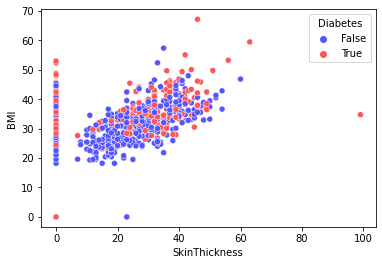

In [7]:
sns.scatterplot(data=df, x="SkinThickness", y="BMI", hue="Diabetes", palette='seismic')
# Insights:
# SkinThickness and BMI have a correlation value of 0.393
# A high SkinThickness usually means a higher BMI
# A high BMI means a higher chance of Diabetes
# Also age and Diabetes has a correlation value of 0.238

In [8]:
# Data Preprocessing
# Normalizing continuous features
df.describe().T[['min', 'mean', 'max']][:-1].style.background_gradient(cmap='Blues')

,min,mean,max
Pregnancies,0.000000,3.845052,17.000000
Glucose,0.000000,120.894531,199.000000
BloodPressure,0.000000,69.105469,122.000000
SkinThickness,0.000000,20.536458,99.000000
Insulin,0.000000,79.799479,846.000000
BMI,0.000000,31.992578,67.100000
DiabetesPedigreeFunction,0.078000,0.471876,2.420000


In [9]:
# All features are continuous, but they all have different ranges, so we're normalizing them to be between 0 and 1
for col in ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
            'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']:
    df[col] = df[col]/df[col].max()

In [10]:
# Detect null records
df.isnull().sum()
# Insight: the data is already clean and there's no missing records

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Diabetes                    0
dtype: int64

In [11]:
# Splitting data to testing and training
features = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
            'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']]
labels = df['Diabetes']

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=0)

In [12]:
# Building model
rfc=RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [80, 100, 500],
    'max_features': ['auto', 'sqrt', 'log2'], 
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']    # The function to measure the quality of a split
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(x_train, y_train)

CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'max_features': 'log2',
 'n_estimators': 80}

In [13]:
rfc1=RandomForestClassifier(random_state=42, max_features='log2', n_estimators= 80, max_depth=4, criterion='entropy')
rfc1.fit(x_train, y_train)

# Predict on the test set results
y_pred = rfc1.predict(x_test)

# Check accuracy score 
print('Model accuracy score with all variables: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with all variables: 0.7708


In [14]:
# Use the feature importance variable to see feature importance scores.
feature_scores = pd.Series(rfc1.feature_importances_, index=x_train.columns).sort_values(ascending=False)
feature_scores

Glucose                     0.360173
BMI                         0.255688
Age                         0.167652
DiabetesPedigreeFunction    0.078852
Pregnancies                 0.039197
Insulin                     0.039057
BloodPressure               0.030143
SkinThickness               0.029239
dtype: float64

In [15]:
# Interpretation
# The above analysis confirms that the most important feature is Glucose and least important feature is skinThickness

# Build the Random Forest model on selected features 
# drop the least important feature from X_train and X_test

x_train = x_train.drop(['SkinThickness', 'BloodPressure'], axis=1)
x_test = x_test.drop(['SkinThickness', 'BloodPressure'], axis=1)

clf=RandomForestClassifier(random_state=42, max_features='log2', n_estimators= 80, max_depth=4, criterion='entropy')
# fit the model to the training set
clf.fit(x_train, y_train)
# Predict on the test set results
y_pred = clf.predict(x_test)

# Check accuracy score 
print('Model accuracy score with SkinThickness and BloodPressure variables removed : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with SkinThickness and BloodPressure variables removed : 0.7865


In [16]:
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

Confusion matrix

 [[118  12]
 [ 29  33]]


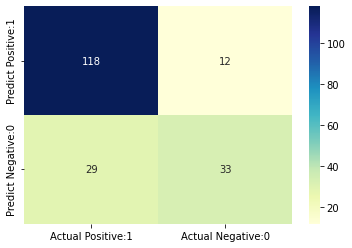

In [17]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [18]:
from sklearn.metrics import classification_report

# Show classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.80      0.91      0.85       130
        True       0.73      0.53      0.62        62

    accuracy                           0.79       192
   macro avg       0.77      0.72      0.73       192
weighted avg       0.78      0.79      0.78       192

